# Atomic and magnetic PDF co-refinement using SrFit

This notebook provides examples of joint atomic and magnetic PDF fits using two approaches: a true simultaneous corefinement and an iterative refinement that toggles between atomic and magnetic parameters. We will again use MnO as our test case.

### Import necessary modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from diffpy.mpdf import *
from diffpy.structure.parsers import getParser
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.srfit.fitbase import FitRecipe, FitResults
from diffpy.srfit.fitbase import Profile, FitContribution
from diffpy.structure import loadStructure

%matplotlib notebook

### Approach 1: Simultaneous corefinement

In the code below, we define a fitting function that includes both the atomic and magnetic PDF and allow all the parameters to be optimized simultaneously. Note that we use the rhombohedral unit cell for MnO in the distorted antiferromagnetic state. In this setting, the magnetic propagation vector is k = (0, 0, 1.5).

In [5]:
def combined_fit(dataFile, structureFile, rmin=1.5, rmax=20.0, method='corefinement'):
    """
    method = 'corefinement': true simultaneous corefinement of atomic and magnetic parameters
    method = 'toggle': iterative fit that toggles between atomic and magnetic parameters
    """
    # load in the starting structure
    pcif = getParser('cif')
    struc = pcif.parseFile(structureFile)

    # prepare profile object with experimental data
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(dataFile)
    profile.loadParsedData(parser)
    
    # define qdamp and qbroad (determined previously from calibration fits)
    qdamp = 0.024
    qbroad = 0.025

    # set up calculation range for the PDF simulation
    rstep = 0.01
    profile.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)

    # prepare nucpdf function that calculates the atomic PDF
    nucpdf = PDFGenerator("nucpdf")
    nucpdf.setStructure(struc)
    nucpdf.setProfile(profile)

    # prepare a FitContribution object that will include the atomic and magnetic PDF
    totpdf = FitContribution('totpdf')
    totpdf.addProfileGenerator(nucpdf) # we'll add the mPDF later
    totpdf.setProfile(profile)

    # set up the MagSpecies
    mspec = MagSpecies(struc=struc,rmaxAtoms=rmax,ffparamkey='Mn2')
    mspec.strucIdxs = [0, 1, 2] # determined from previous inspection of the unit cell
    mspec.basisvecs = np.array([1, -1, 0])
    mspec.kvecs = np.array([0, 0, 1.5]) # this gives the desired AF structure for this choice of unit cell

    # set up the MagStructure
    mstruc = MagStructure(rmaxAtoms=rmax)
    mstruc.loadSpecies(mspec)
    mstruc.makeAll() ### populates the spin and atom arrays

    # create the MPDFcalculator for MnO
    mc = MPDFcalculator(magstruc=mstruc,qdamp=qdamp,rmax=rmax,rmin=rmin)

    # Define an mPDF function that will be added to the total PDF calculator
    def mpdf(ordscale,parascale,th,phi):
        """
        ordscale = ordered scale factor (mc.ordScale)
        parascale = paramagnetic scale factor (mc.paraScale)
        th, phi = polar and azimuthal angles of sublattice magnetization direction
        """
        mc.ordScale = ordscale
        mc.paraScale = parascale
        # define a new sublattice magnetization direction based on th, phi
        newSvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
        # update the MagStructure with the new spin directions
        mspec.basisvecs = 1.0*newSvec
        mstruc.makeAll()
        # return the "unnormalized" mPDF
        rcalc, fcalc, dcalc = mc.calc(both=True)
        return dcalc

    # add mPDF to the FitContribution
    totpdf.registerFunction(mpdf)
    totpdf.setEquation("nucscale * nucpdf + mpdf(ordscale,parascale,th,phi)")

    # Make magnetic PDF depend on any changes to the atomic structure.
    # A structure change will now trigger reevaluation of the mPDF.
    nucpdf.phase.addObserver(totpdf.ordscale.notify)

    # set up the FitRecipe
    fit = FitRecipe()
    fit.addContribution(totpdf)

    # fix qdamp and qbroad based on prior information
    fit.addVar(nucpdf.qdamp, qdamp, fixed=True, name='qdamp')
    fit.addVar(nucpdf.qbroad, qbroad, fixed=True, name='qbroad')

    # Configure the fit variables and give them to the recipe.
    from diffpy.srfit.structure import constrainAsSpaceGroup
    sgpars = constrainAsSpaceGroup(nucpdf.phase, pcif.spacegroup.short_name)

    for par in sgpars.latpars:
        fit.addVar(par,tag='LatPars') # we will use these tags later
    for par in sgpars.adppars:
        fit.addVar(par, value=0.003, tag='ADPs')

    # note that there are no positional degrees of freedom (i.e. xyz parameters) for this structure
        
    fit.addVar(totpdf.nucscale, 0.05, name='nucscale')
    fit.addVar(nucpdf.delta1, value=1.0, name='delta1')

    # mPDF parameters
    fit.addVar(totpdf.parascale, 0, tag='Mag')
    rstPs = fit.restrain(totpdf.parascale,lb=0,ub=10.0,sig=0.0001) # set reasonable bounds
    fit.addVar(totpdf.ordscale, 0.0, tag='Mag')
    rstOs = fit.restrain(totpdf.ordscale,lb=0,ub=10.0,sig=0.0001)
    fit.addVar(totpdf.th,np.pi/2.0, tag='Mag')
    rstTh = fit.restrain(totpdf.th,lb=0,ub=np.pi,sig=0.0001)
    fit.addVar(totpdf.phi,0, tag='Mag')
    rstPhi = fit.restrain(totpdf.phi,lb=-np.pi,ub=np.pi,sig=0.0001)

    # Turn off printout of iteration number.
    fit.clearFitHooks()
    fit.fix('all')

    if method == 'corefinement':
        # start with scale factor and lattice parameters
        fit.free('nucscale')
        fit.free('LatPars') # we use the tag LatPars to free all the lattice parameters
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # skipping xyz parameters because there are none in this symmetry

        # add the ADps
        fit.free('ADPs')
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # add delta1
        fit.free('delta1')
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # add the magnetic parameters
        fit.free('Mag')
        print(fit.names)
        least_squares(fit.residual,fit.values)

    if method == 'toggle':
        numIterations = 3 # number of times to toggle between atomic and magnetic parameters
        for i in range(numIterations):
            # start with scale factor and lattice parameters
            fit.free('nucscale')
            fit.free('LatPars') # we use the tag LatPars to free all the lattice parameters
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # skipping xyz parameters because there are none in this symmetry

            # add the ADps
            fit.free('ADPs')
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # add delta1
            fit.free('delta1')
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # now fix all the atomic parameters and free the magnetic parameters
            fit.fix('all')

            fit.free('Mag')
            print(fit.names)
            magOpt = least_squares(fit.residual,fit.values)
            
            if i < (numIterations - 1):
                fit.fix('all') # fix all the parameters and start the loop again

    # Display results and plot the fit
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate() # calculated combined atomic and magnetic PDF
    magcalc = mpdf(fit.ordscale.value,fit.parascale.value,fit.th.value,fit.phi.value) # just mPDF
    nuccalc = totcalc - magcalc # just atomic PDF
    baseline = 1.2 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc # total fit residual
    results = FitResults(fit)
    print('Rw = '+str(results.rw))

    # Plot the structural refinement
    ax=plt.figure().add_subplot(111)
    ax.plot(r, gobs, 'bo', label="G(r) data",markerfacecolor='none', markeredgecolor='b')
    ax.plot(r, totcalc, 'r-', lw=1.5, label="Total fit")
    ax.plot(r, nucdiff + baseline, marker='o',mec='Gray',mfc='None')
    ax.plot(r, magcalc + baseline, marker='None',color='Blue',lw=2, label='mPDF fit')
    ax.plot(r, totdiff+1.4*baseline, 'g-')
    ax.plot(r, np.zeros_like(r) + 1.4*baseline, 'k:')


    ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
    ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
    plt.legend()

    plt.show()

Let's do a true corefinement first.

['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta1']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta1', 'parascale', 'ordscale', 'th', 'phi']
Rw = 0.07158523554070431


<IPython.core.display.Javascript object>


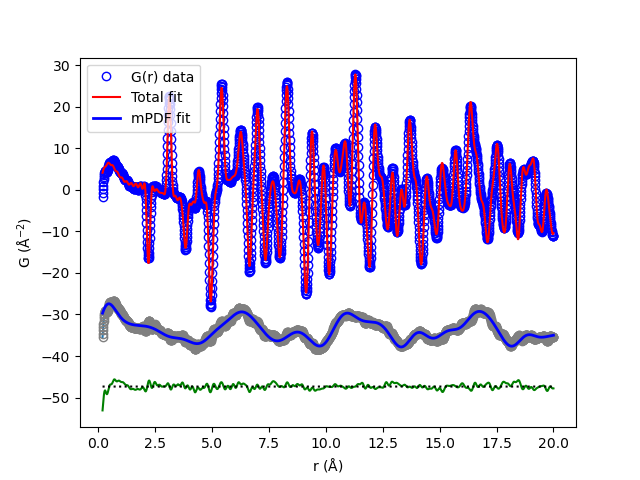

In [6]:
dataFile = 'NOM_9999_MnO_5K_ftfrgr.gr'
structureFile = 'MnO_R-3m.cif'

combined_fit(dataFile, structureFile, rmin=0.2, rmax=20, method='corefinement')

And now an iterative fit toggling between atomic and magnetic parameters.

['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta1']
['parascale', 'ordscale', 'th', 'phi']
['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta1']
['parascale', 'ordscale', 'th', 'phi']
['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta1']
['parascale', 'ordscale', 'th', 'phi']
Rw = 0.07140681617244672


<IPython.core.display.Javascript object>


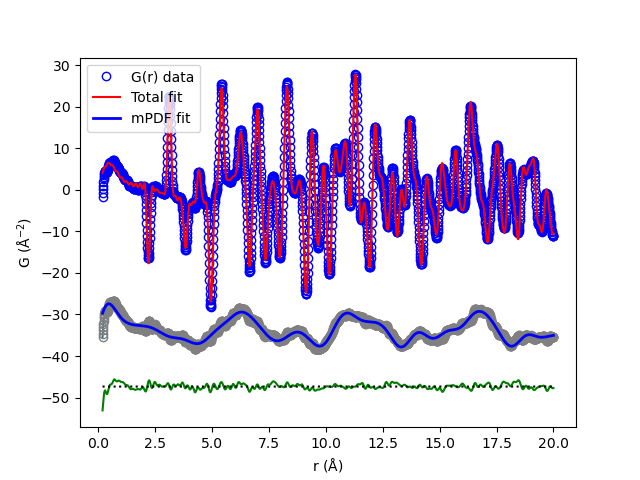

In [7]:
combined_fit(dataFile, structureFile, rmin=0.2, rmax=20, method='toggle')

The results are essentially indistinguishable, although the toggling method gives a very slightly better fit (in the 4th decimal place of Rw). Sometimes toggling works slightly better and other times corefinement does, so it may be worth trying both methods for your data set.

In [27]:
plt.close('all')